In [1]:
#### DO NOT RUN THIS CODE IN THE NOTEBOOK - copy paste into terminal in the HOME directory!

# git clone https://github.com/tensorflow/models.git

In [2]:
 # !pip install s3fs -q
 # !pip install tensorflow_hub -q
 # !pip install tensorflow_datasets -q
 # !pip install pycocotools -q
 # !pip install gin-config -q
 # !pip install immutabledict -q
 # !pip install sentencepiece -q
 # !pip install transformers -q
 # !pip install -r official/projects/movinet/requirements.txt -q

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import configparser

config = configparser.ConfigParser()
config.read('/home/ec2-user/.aws/credentials')

['/home/ec2-user/.aws/credentials']

In [5]:
# AWS credentials and S3 settings
aws_access_key_id = config["default"]['aws_access_key_id']
aws_secret_access_key = config["default"]['aws_secret_access_key']
bucket_name = 'asl-capstone'
s3_URI = 's3://asl-capstone/'

In [6]:
import s3fs
fs = s3fs.S3FileSystem(key=aws_access_key_id, secret=aws_secret_access_key)

import boto3
s3 = boto3.client('s3',aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key,
                  region_name = 'us-west-2')


In [7]:
import tensorflow as tf, tf_keras
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import requests
from typing import List, Tuple
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

tf.keras.backend.clear_session()

2023-11-28 17:53:23.372218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 17:53:25.093015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
%cd /home/ec2-user/models

/home/ec2-user/models


In [9]:
pwd

'/home/ec2-user/models'

In [10]:
# # !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz
# !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a3_base.tar.gz
# # !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a5_base.tar.gz
# # !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a5_base_k400.tar.gz

# # !tar -xf movinet_a5_base_k400.tar.gz
# # !mv movinet_a5_base movinet_a5_base_k400
# # !tar -xf movinet_a0_base.tar.gz
# !tar -xf movinet_a3_base.tar.gz
# # !tar -xf movinet_a5_base.tar.gz

In [11]:
model_version = 'a2'

if model_version=='a3':
  max_frames = 120
  image_dims = (256,256)
elif model_version=='a2':
  max_frames = 80
  image_dims = (224,224)
elif model_version=='a0':
  max_frames = 50
  image_dims = (172,172)


from official.projects.movinet.modeling import movinet

if model_version == 'a3':
    from official.projects.movinet.modeling import movinet_model_a3_modified as movinet_model_modified
elif model_version == 'a2':
    from official.projects.movinet.modeling import movinet_model_a2_modified as movinet_model_modified


In [12]:
# # Get the kinetics-600 action labels
# KINETICS_URL = "official/projects/movinet/files/kinetics_600_labels.txt"
# with open(KINETICS_URL) as obj:
#   labels_600 = [line for line in obj.readlines()]
# print("Found %d labels." % len(labels_600))

In [13]:
# vid1 = pd.read_parquet('s3://asl-capstone/wlasl/video_mappings_masterfile.parquet', 
#                        columns=['word','rgb_path','padded_path'])


# vid2 = pd.read_parquet('s3://asl-capstone/msasl/video_mappings_masterfile.parquet')
# vid2 = vid2.rename(columns={'caption':'word', 'path':'rgb_path'})
# vid2['padded_path'] = vid2.rgb_path.replace('/RGB/', '/padded/')

# video_files = pd.concat([vid1, vid2], axis=0)

# label_nums = video_files.word.value_counts().reset_index().reset_index().rename(columns={'index':'label_num'})

# label_nums.to_parquet('s3://asl-capstone/movinet_word_labels.parquet')

# video_files = video_files.merge(label_nums, on='word')
# video_files = video_files.drop_duplicates()
# video_files['padded_path'] = video_files['padded_path'].str.replace('/RGB/', '/padded/')
# video_files.to_parquet('s3://asl-capstone/movinet_masterfile_mappings.parquet')

In [14]:
video_files = pd.read_parquet('s3://asl-capstone/movinet_masterfile_mappings.parquet')

In [15]:
display(video_files.head())
print(video_files.shape)
print(video_files.word.nunique())

# media.show_video(vid, codec='gif', fps=10)

,word,rgb_path,padded_path,label_num,count
0,viewpoint,asl-capstone/wlasl/RGB/viewpoint_0.npy,asl-capstone/wlasl/padded/viewpoint_0.npy,1387,5
1,viewpoint,asl-capstone/wlasl/RGB/viewpoint_1.npy,asl-capstone/wlasl/padded/viewpoint_1.npy,1387,5
2,viewpoint,asl-capstone/wlasl/RGB/viewpoint_2.npy,asl-capstone/wlasl/padded/viewpoint_2.npy,1387,5
3,viewpoint,asl-capstone/wlasl/RGB/viewpoint_3.npy,asl-capstone/wlasl/padded/viewpoint_3.npy,1387,5
4,viewpoint,asl-capstone/wlasl/RGB/viewpoint_4.npy,asl-capstone/wlasl/padded/viewpoint_4.npy,1387,5


(25479, 5)
1997


In [16]:
video_files['padded_path'] = video_files['padded_path'].str.replace('/RGB/', '/padded/')

In [17]:
video_files.word.value_counts()[:10]

word
africa       72
afternoon    70
afraid       54
again        45
accident     43
thin         36
before       36
adopt        36
tall         33
cousin       33
Name: count, dtype: int64

In [18]:
smaller_samples = video_files[video_files['count']<=50]
larger_samples = video_files[video_files['count']>50].groupby('word').sample(50)

video_files = pd.concat([smaller_samples,larger_samples])
video_files.word.value_counts()[:10]

word
afternoon    50
africa       50
afraid       50
again        45
accident     43
thin         36
adopt        36
before       36
tall         33
cousin       33
Name: count, dtype: int64

In [19]:
video_files[video_files['count'] >= 27].word.nunique()

107

In [20]:
# count = video_files.word.value_counts()[:200][-1]
# words = video_files.word.value_counts()[video_files.word.value_counts() >= count].reset_index()['word'].unique()

# video_files = video_files[video_files.word.isin(words)]

video_files = video_files[video_files['count'] >= 27]

video_files.shape

(3148, 5)

In [21]:
NUM_CLASSES = video_files.word.nunique()
NUM_CLASSES

107

In [22]:
# print(video_files['frame_count'].mean())
# print(video_files['frame_count'].median())
# print(video_files['frame_count'].max())

In [ ]:
if model_version=='a2':
    video_files['padded_path'] = video_files['padded_path'].str.replace('/padded/', '/padded_a2/')

In [23]:
train_files, test_files = train_test_split(video_files, train_size=0.8)
print(train_files.shape)
print(test_files.shape)

(2518, 5)
(630, 5)


In [24]:
train_files['flip'] = False

bootstrap = train_files.groupby('word').sample(2)
bootstrap['flip'] = True

train_files = pd.concat([train_files, bootstrap]).sample(frac=1)
train_files.shape

(2732, 6)

In [25]:
def data_generator(file_paths_df, add_flip=False):
    for _, row in file_paths_df.iterrows():
        with fs.open(row['padded_path'], 'rb') as f:
            video = np.load(f)[:max_frames]

        if add_flip:
            if row['flip']==True:
                video = np.flip(video, axis=2)

        video = tf.convert_to_tensor(video)

        if model_version=='a2':
            video = tf.image.resize(video, image_dims)

        label = tf.one_hot(row['label_num'], NUM_CLASSES)
        yield video, label


# Create TensorFlow Dataset for model input. 
train_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(train_files, add_flip=True),
    output_signature=(
        tf.TensorSpec(shape=(max_frames, image_dims[0], image_dims[1], 3)),
        tf.TensorSpec(shape=(NUM_CLASSES), dtype=tf.int32)
    )
)

# Create TensorFlow Dataset for model input. 
test_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(test_files),
    output_signature=(
        tf.TensorSpec(shape=(max_frames, image_dims[0], image_dims[1], 3)),
        tf.TensorSpec(shape=(NUM_CLASSES), dtype=tf.int32)
    )
)

2023-11-28 17:53:33.007725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 17:53:33.336398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 17:53:33.338708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [26]:
#next(iter(train_dataset.batch(1))) #Does a sanity check to confirm that the dataset is processed in batches

In [27]:
# Create backbone and model.
backbone = movinet.Movinet(
    model_id=model_version, #change to correspond to model
    causal=False,
    use_external_states=False,
)

In [28]:
def build_classifier(backbone, num_classes, encoder_dim=768, dropout_rate=0.05):
    """Builds a classifier on top of a backbone model."""
    model = movinet_model_modified.MovinetClassifier(
        backbone=backbone,
        num_classes=num_classes, 
        encoder_dim=encoder_dim, 
        dropout_rate=dropout_rate)
    model.build([2, max_frames, image_dims[0], image_dims[1], 3])

    model.layers[0].trainable = False
    model.layers[1].trainable = True
    model.layers[-1].trainable = True

    if model_version == 'a2':
        for i in range(21):
            model.layers[1].layers[i].trainable = False
    elif model_version == 'a3':
        for i in range(25):
            model.layers[1].layers[i].trainable = False

    model.layers[1].layers[-1].trainable = False

    return model

# Wrap the backbone with a new classifier to create a new classifier head
# with num_classes outputs (101 classes for UCF101).
# Freeze all layers except for the final classifier head.
model = build_classifier(backbone, NUM_CLASSES, encoder_dim=768, dropout_rate=0.05)

In [29]:
model.summary()

Model: "movinet_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    2738754   
                             None, None, 16),                    
                              'block0_layer0': (None             
                             , None, None, None, 16)             
                             , 'block0_layer1': (Non             
                             e, None, None, None, 16             
                             ),                                  
                              'block0_layer2': (None             
                             , None, None, None, 16)             
                             , 'block1_layer0': 

In [30]:
for i in range(len(model.layers[1].layers)):
    print(model.layers[1].layers[i].name, i, model.layers[1].layers[i].trainable)

inputs 0 False
stem 1 False
block0_layer0 2 False
block0_layer1 3 False
block0_layer2 4 False
block1_layer0 5 False
block1_layer1 6 False
block1_layer2 7 False
block1_layer3 8 False
block1_layer4 9 False
block2_layer0 10 False
block2_layer1 11 False
block2_layer2 12 False
block2_layer3 13 False
block2_layer4 14 False
block3_layer0 15 False
block3_layer1 16 False
block3_layer2 17 False
block3_layer3 18 False
block3_layer4 19 False
block3_layer5 20 False
block4_layer0 21 True
block4_layer1 22 True
block4_layer2 23 True
block4_layer3 24 True
block4_layer4 25 True
block4_layer5 26 True
block4_layer6 27 True
head 28 False


In [31]:
# import tensorflow_model_optimization as tfmot

# # q_aware stands for for quantization aware.
# q_aware_model = tfmot.quantization.keras.quantize_apply(model)


# Dense layers should be quantized.
# def apply_quantization_to_dense(layer):
#   if isinstance(layer, tf.keras.layers.Dense):
#     return tfmot.quantization.keras.quantize_annotate_layer(layer)
#   return layer

# # Use `tf.keras.models.clone_model` to apply `apply_quantization_to_dense` 
# # to the layers of the model.
# annotated_model = tf.keras.models.clone_model(
#     base_model,
#     clone_function=apply_quantization_to_dense,
# )

# # Now that the Dense layers are annotated,
# # `quantize_apply` actually makes the model quantization aware.
# quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

# quant_aware_model.summary()

In [32]:
NUM_EPOCHS = 2
BATCH_SIZE = 16

train_steps = len(train_files) // BATCH_SIZE
total_train_steps = train_steps * NUM_EPOCHS

test_steps = len(test_files) // BATCH_SIZE

loss_obj = tf_keras.losses.CategoricalCrossentropy(
    from_logits=True, #label_smoothing=0.05
    )

metrics = [
    tf_keras.metrics.TopKCategoricalAccuracy(
        k=1, name='top_1', dtype=tf.float32),
    tf_keras.metrics.TopKCategoricalAccuracy(
        k=5, name='top_5', dtype=tf.float32),
]

initial_learning_rate = 0.001
learning_rate = tf_keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps, warmup_target=0.1, warmup_steps=20
)

optimizer = tf_keras.optimizers.RMSprop(learning_rate=learning_rate,
                                        rho=0.9, momentum=0.9, 
                                        epsilon=1.0, clipnorm=1.0)


model.compile(loss={'prediction':loss_obj, 'vid_embedding':None}, 
              optimizer=optimizer, 
              metrics={'prediction':metrics, 'vid_embedding':None})


# look into quantization for tf

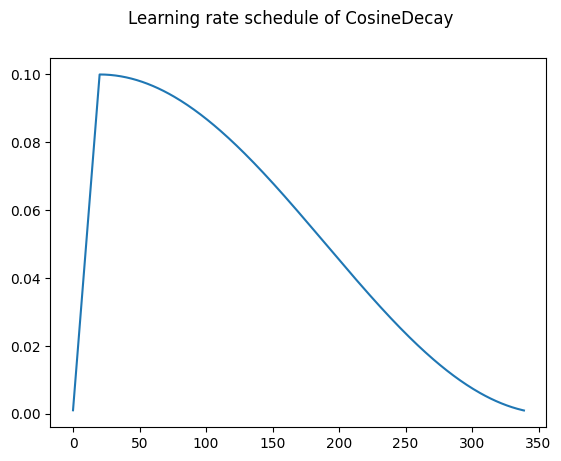

In [33]:
%matplotlib inline

def visualize_lr_schedule(opt, n_steps, step_s) -> Tuple[List[int], List[float]]:
    """Visualize tensorflow keras scheduler learning rate over the course of n_steps training steps.

    Args:
        opt (LearningRateSchedule): learning rate scheduler to be visualized.
        n_steps (int): number of training steps to visualize over.
        step_s (int): sampling step of the training steps, i.e. takes each step_s in the interval [0, n_steps].

    Returns:
        Tuple[List[int], List[float]]: returns x (steps), y (lr values) values of the plot.
    """
    lr = []
    steps = list(range(0, n_steps, step_s))

    for step in steps:
        lr_at_s = opt(step).numpy()
        lr.append(lr_at_s)

    plt.suptitle(f'Learning rate schedule of {type(opt).__name__}')
    plt.plot(steps, lr)

    return steps, lr


steps, lr_values = visualize_lr_schedule(learning_rate, n_steps=total_train_steps, step_s=1)

In [ ]:
# takes about 5 mins from start to find out if this will fail or not
# got through 4 epochs in 12 minutes
results = model.fit(
                train_dataset.batch(BATCH_SIZE, drop_remainder=True),
                validation_data=test_dataset.batch(BATCH_SIZE, drop_remainder=True),
                epochs=NUM_EPOCHS,
                verbose=1)

# Epoch 1
# movinet a2
# 170/Unknown - 22561s 132s/step - loss: 4.8491 - classifier_head_loss: 4.8491 - classifier_head_top_1: 0.0184 - classifier_head_top_5: 0.0783


# Epoch 1
# 103/103 7429s 71s/step - loss: 5.7013 - classifier_head_loss: 5.7013 - classifier_head_top_1: 0.0206 - classifier_head_top_5: 0.1214 - val_loss: 1163.0439 - val_classifier_head_loss: 1163.0439 - val_classifier_head_top_1: 0.0147 - val_classifier_head_top_5: 1.0000


# Epoch 1 partial, 696 classes (with counts >20)
# 149/Unknown - 8534s 56s/step - loss: 6.7610 - classifier_head_loss: 6.7610 - classifier_head_top_1: 0.0034 - classifier_head_top_5: 0.0084

Epoch 1/2


2023-11-28 17:58:13.122412: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x200993c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-28 17:58:13.122449: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-28 17:58:16.296708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-28 17:58:22.451304: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-28 17:58:56.728590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-28 17:58:58.002676: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


     56/Unknown - 7236s 127s/step - loss: 6.5408 - classifier_head_loss: 6.5408 - classifier_head_top_1: 0.0123 - classifier_head_top_5: 0.0558

In [ ]:
model.save('/home/ec2-user/ASL-Translator/modeling/movinet_checkpoints')

In [ ]:
model.save('/home/ec2-user/ASL-Translator/modeling/movinet_a2_finetuned.h5')

In [ ]:
# checkpoint = tf.train.Checkpoint(model)
# path_saving = checkpoint.save('/tmp/training_checkpoints')

In [ ]:
def get_instance_id():
    """Get current instance ID from metadata"""
    url = "http://169.254.169.254/latest/meta-data/instance-id"
    response = requests.get(url)
    return response.text

def stop_instance(instance_id, region_name='us-west-2'):
    """Stop the EC2 instance"""
    ec2 = boto3.client('ec2', aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key, region_name=region_name)
    ec2.stop_instances(InstanceIds=[instance_id])

In [ ]:
# Get the current instance ID
instance_id = get_instance_id()
print(instance_id)
# Stop the instance
stop_instance(instance_id)

In [ ]:
results = model.fit(
                train_dataset.batch(BATCH_SIZE), #14, lr = 0.001, Adafactor, 656 classes
                validation_data=test_dataset.batch(BATCH_SIZE),
                epochs=NUM_EPOCHS,
                steps_per_epoch=train_steps,
                validation_steps=test_steps,
                verbose=1)

# 14/268 ETA: 7:43:44 - loss: 2.0779 - classifier_head_loss: 2.0779 - classifier_head_top_1: 0.0051 - classifier_head_top_5: 0.0204

 14/268 [>.............................] - ETA: 7:43:44 - loss: 2.0779 - classifier_head_loss: 2.0779 - classifier_head_top_1: 0.0051 - classifier_head_top_5: 0.0204

In [28]:
results = model.fit(
                train_dataset.batch(BATCH_SIZE), #12, lr = 0.01, adafactor, 656 classes
                validation_data=test_dataset.batch(BATCH_SIZE),
                epochs=NUM_EPOCHS,
                steps_per_epoch=train_steps,
                validation_steps=test_steps,
                verbose=1)

# 313/313 - ETA: 0s - loss: 5.5397 - classifier_head_loss: 5.5397 - classifier_head_top_1: 0.0013 - classifier_head_top_5: 0.0077 

2023-11-20 17:03:26.068579: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f8be1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-20 17:03:26.068629: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-20 17:03:29.061197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-20 17:03:36.363940: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-20 17:04:24.872884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-20 17:04:24.910181: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


313/313 [==============================] - ETA: 0s - loss: 5.5397 - classifier_head_loss: 5.5397 - classifier_head_top_1: 0.0013 - classifier_head_top_5: 0.0077  

KeyboardInterrupt: 

In [ ]:
# with tf.device("/GPU:0"):
results = model.fit(
                train_dataset.batch(BATCH_SIZE), #12, lr = 0.1, adafactor, 2000 classes
                validation_data=test_dataset.batch(BATCH_SIZE),
                epochs=NUM_EPOCHS,
                steps_per_epoch=train_steps,
                validation_steps=test_steps,
                verbose=1)
    
# results = q_aware_model.fit(
#                 train_dataset.batch(BATCH_SIZE),
#                 validation_data=test_dataset.batch(BATCH_SIZE),
#                 epochs=NUM_EPOCHS,
#                 steps_per_epoch=train_steps,
#                 validation_steps=test_steps,
#                 verbose=1)

# 122/313 - ETA: 4:38:20 - loss: 5.8746 - classifier_head_loss: 5.8746 - classifier_head_top_1: 6.8306e-04 - classifier_head_top_5: 0.0027

2023-11-20 03:25:05.520218: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x20fa2680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-20 03:25:05.520269: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-20 03:25:06.600233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-20 03:25:11.734728: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-20 03:26:00.069649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-20 03:26:00.080313: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


122/313 [==========>...................] - ETA: 4:38:20 - loss: 5.8746 - classifier_head_loss: 5.8746 - classifier_head_top_1: 6.8306e-04 - classifier_head_top_5: 0.0027